# SPML HW3 - Universal Adversarial Perturbation (30)

### Deadline: 1402/2/30

#### Name: Javad Hezareh
#### Student No.: 98101074

**Initial Setups** 

In [2]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np

from torch.utils.data import DataLoader

# Please use CUDA

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))


# download resnet module
resnet_url = "https://raw.githubusercontent.com/kuangliu/pytorch-cifar/master/models/resnet.py"
!wget $resnet_url


# Let's try Drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir ./myCIFAR10

cuda
Tesla T4
--2023-06-13 07:53:06--  https://raw.githubusercontent.com/kuangliu/pytorch-cifar/master/models/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4218 (4.1K) [text/plain]
Saving to: ‘resnet.py.1’

resnet.py.1         100%[===================>]   4.12K  --.-KB/s    in 0s      

2023-06-13 07:53:06 (57.1 MB/s) - ‘resnet.py.1’ saved [4218/4218]

/content/drive/MyDrive
mkdir: cannot create directory ‘./myCIFAR10’: File exists


**Installing & Importing torchattacks for deepfool**

In [1]:
"""
Deepfool attack is used in UAP algorithm
We suggest to use torchattacks library and its implemented DeepFool
"""

!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git

import torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Harry24k/adversarial-attacks-pytorch.git to /tmp/pip-req-build-y35n6uqc
  Running command git clone --filter=blob:none --quiet https://github.com/Harry24k/adversarial-attacks-pytorch.git /tmp/pip-req-build-y35n6uqc
  Resolved https://github.com/Harry24k/adversarial-attacks-pytorch.git to commit c4da6a95546283992a3d1816ae76a0cd4dfc2d8b
  Preparing metadata (setup.py) ... done



**[1] Projection function**

In [3]:
#In this function you wil implement projection due to the given norm (p) 
#For now, only p = 2 and p = Inf is needed to be supported by your function
#Project on the lp ball centered at 0 and of radius e

def proj_lp(v, e, p):

    if p == 2:
        #Your code goes here
        v = e * (v / torch.norm(v))
    elif p == np.inf:
        #Your code goes here
        v = torch.clamp(v, min=-e, max=e)
    else:
         raise ValueError('Values of p different from 2 and Inf are currently not supported!')
    return v

**[2] UAP generation**

In [22]:
#In this function you will implement UAP algorithm for generating a universal perturbation based on the given dataset and model

def universal_pert(dataset, model, delta=0.1, max_iter_uni=np.inf, eps=10, p=np.inf, num_classes=10, df_overshoot=0.02, df_steps=10):
    '''
    :param dataset: Pytorch Dataset
    :param model: Model to be fooled by the adversarial examples
    :param delta: 1-delta represents the fooling_rate, and the objective (default = 90% fooling rate)
    :param max_iter_uni: Maximum number of iterations of the main algorithm
    :param eps: Controls the l_p magnitude of the perturbation (default = 10)
    :param p: Only p==2 or p==infinity are supported
    :param num_classes: Number of classes on the dataset
    :param df_overshoot: Parameter to the Deep_fool algorithm
    :param df_steps: Maximum iterations of the deep fool algorithm
    :return: perturbation found (and also fooling_rates for iterations and number of total_iterations)
    '''

    model.eval()

    # Initializing the perturbation to 0s
    v = torch.zeros_like(dataset[0][0]).to(device)


    #Initializing fooling rate and iteration count
    fooling_rate = 0.0
    iter = 0
    
    fooling_rates = []
    total_iterations = []

    """
    Begin of the main loop on Universal Adversarial Perturbations algorithm
    (Provide the conditions due to given delta and maximum number of iterations)
    """
    attack_model = torchattacks.DeepFool(model, steps=df_steps, overshoot=df_overshoot)

    while fooling_rate <= 1 - delta:
        print ('Starting pass number ', iter)

        # Go through the trainset and compute the perturbation increments sequentially
        for i, data in enumerate(dataset):
            image, label = data
            image = image.reshape([1,3,32,32]).to(device)

            #Complete the code due to the UAP algorithm
            true_out = model(image)
            pert_out = model(torch.clip(image + v, 0, 1))
            fooled = (torch.argmax(pert_out, dim=1) != torch.argmax(true_out, dim=1))

            if not fooled:
                print('>> k = ', i, ', iter #', iter)
                #Finding a new minimal perturbation with deepfool to fool the network on this image
                #your code goes here
                adv_img = attack_model(torch.clip(image + v, 0, 1), torch.argmax(true_out, dim=1))
                dv = adv_img - torch.clip(image + v, 0, 1)
                
                #Update v appropriately
                #your code goes here
                v = proj_lp(v + dv, eps, p)
                
        iter = iter + 1

        with torch.no_grad():
            batch_size = 128
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            total = 0
            fooled = 0

            """Calculate fooling rate
            (Go through the dataset and check that v can fool the model or not. Calculate the ratio of fooled samples to total number of samples.)
            """
            for imgs, labels in dataloader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                true_out = model(imgs)
                pert_out = model(torch.clip(imgs + v, 0, 1))

                true_pred = torch.argmax(true_out, dim=1)
                pert_pred = torch.argmax(pert_out, dim=1)

                total += len(labels)
                fooled += (true_pred != pert_pred).sum().item()
            
        fooling_rate = fooled / total
        torch.cuda.empty_cache()

        print("FOOLING RATE: ", fooling_rate)
        fooling_rates.append(fooling_rate)
        total_iterations.append(iter)

    return v,fooling_rates,total_iterations



**Loading CIFAR10**

In [5]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

cifar_trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = True, download = True, transform = transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

cifar_testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = False, download = True, transform = transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size = batch_size, shuffle = False, num_workers = 2)


Files already downloaded and verified
Files already downloaded and verified


**[3]Loading model**

In [23]:
from resnet import *

model = ResNet18()
model = model.to(device)
model.train()

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


#Load model state dict using the given saved model (The model is trained with CIFAR10 trainset)
#your code goes here
model.load_state_dict(torch.load('/content/drive/MyDrive/SPML_HW4_UAP_resnet18_cifar10_model_std'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

**Generate universal perturbation for CIFAR10 using your function**

In [24]:
#First, split the cifar testset into two distinct dataset (Note that number of samples from each class is balanced in these two dataset.)
#UAP_dataset: 50% of testset for using in your UAP algorithm
#evaluation_dataset: 50% of testset for final evaluation of UAP function (Calculating fooling rates of universal v over unseen cifar test samples)
#Then, use your UAP function for generating universal perturbation

UAP_dataset, evaluation_dataset = torch.utils.data.random_split(cifar_testset, [0.5, 0.5])

v, fooling_rates, total_iterations = universal_pert(UAP_dataset, model)

Streaming output truncated to the last 5000 lines.
>> k =  4050 , iter # 25
>> k =  4070 , iter # 25
>> k =  4074 , iter # 25
>> k =  4077 , iter # 25
>> k =  4080 , iter # 25
>> k =  4089 , iter # 25
>> k =  4095 , iter # 25
>> k =  4104 , iter # 25
>> k =  4117 , iter # 25
>> k =  4134 , iter # 25
>> k =  4136 , iter # 25
>> k =  4140 , iter # 25
>> k =  4171 , iter # 25
>> k =  4174 , iter # 25
>> k =  4178 , iter # 25
>> k =  4180 , iter # 25
>> k =  4187 , iter # 25
>> k =  4203 , iter # 25
>> k =  4207 , iter # 25
>> k =  4216 , iter # 25
>> k =  4217 , iter # 25
>> k =  4230 , iter # 25
>> k =  4232 , iter # 25
>> k =  4242 , iter # 25
>> k =  4245 , iter # 25
>> k =  4253 , iter # 25
>> k =  4259 , iter # 25
>> k =  4266 , iter # 25
>> k =  4283 , iter # 25
>> k =  4296 , iter # 25
>> k =  4297 , iter # 25
>> k =  4308 , iter # 25
>> k =  4309 , iter # 25
>> k =  4313 , iter # 25
>> k =  4326 , iter # 25
>> k =  4327 , iter # 25
>> k =  4329 , iter # 25
>> k =  4333 , iter # 25

**[4] Plot fooling rates over iterations in UAP**



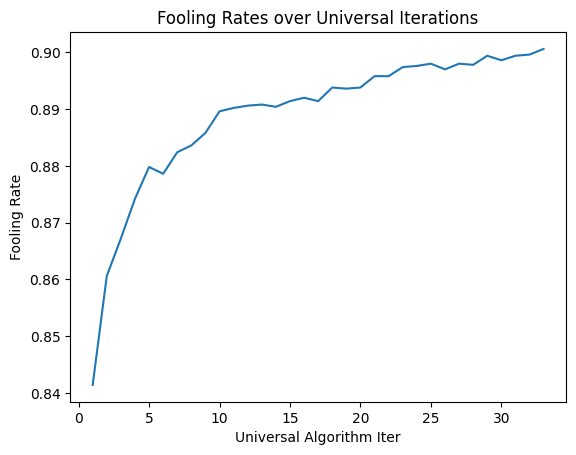

In [25]:
import matplotlib.pyplot as plt

plt.title("Fooling Rates over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Fooling Rate")

plt.plot(total_iterations, fooling_rates)

**[6] Evaluate fooling rate of universal v on testset**

In [26]:
#In this section, you will calculate the ratio of fooled samples to total number of samples over unseen test samples

total = 0
fooled = 0

#check the robustness of model on perturbed test samples with your universal perturbation (output of your algorithm on previous sections)
test_loader = DataLoader(evaluation_dataset, batch_size=128, shuffle=False)
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    true_out = model(imgs)
    pert_out = model(imgs + v)

    true_pred = torch.argmax(true_out, dim=1)
    pert_pred = torch.argmax(pert_out, dim=1)

    total += len(labels)
    fooled += (true_pred != pert_pred).sum().item()

evaluation_fooling_rate = fooled / total
print(evaluation_fooling_rate)

0.8408


In [27]:
torch.save(v.cpu(), '/content/drive/MyDrive/UAP.ptk')

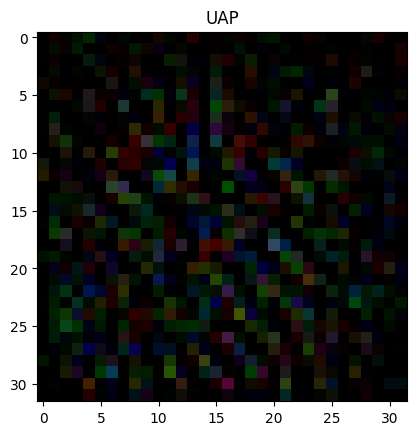

In [29]:
plt.imshow(torch.clip(v, 0, 1).squeeze().permute([1, 2, 0]).cpu().numpy())
plt.title('UAP');